In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Load basemap
To download the ward boundaries basemap, go to [this link](https://datafinder.stats.govt.nz/layer/98740-ward-2019-clipped-generalised/) and look for the button with three dots at the top of the panel on the left.   
Select the option to download the layer, choose the CSV file format and select the `WGS 84 (EPSG:4326 Geographic)` map projection from the dropdown.

In [2]:
# load wards geodata file
basemap = gpd.read_file(
    'data/raw/ward-2019-clipped-generalised.csv'
).drop(
    ['WKT', 'LAND_AREA_SQ_KM', 'AREA_SQ_KM', 'Shape_Length'],
    axis=1
)

# show first 5 rows
basemap.head()

,WARD2019_V1_00,WARD2019_V1_00_NAME,geometry
0,00101,Te Hiku Ward,"MULTIPOLYGON (((173.07153 -34.88197, 173.07134..."
1,00102,Bay of Islands-Whangaroa Ward,"MULTIPOLYGON (((173.57599 -35.15533, 173.57596..."
2,00103,Kaikohe-Hokianga Ward,"MULTIPOLYGON (((173.45685 -35.18914, 173.45706..."
3,00201,Mangakahia-Maungatapere Ward,"MULTIPOLYGON (((173.85809 -35.71772, 173.85360..."
4,00202,Hikurangi-Coastal Ward,"MULTIPOLYGON (((174.15890 -35.53798, 174.15890..."


In [3]:
# set CRS to WGS 84, lat/lon
basemap.crs = {'init' :'epsg:4326'}

# rename columns
basemap.columns = ['Ward_no', 'Ward_name', 'geometry']

# exclude Chatham Islands - as these lie on the other side of the map
basemap = basemap[basemap['Ward_no']!='06799']

basemap.head()

,Ward_no,Ward_name,geometry
0,00101,Te Hiku Ward,"MULTIPOLYGON (((173.07153 -34.88197, 173.07134..."
1,00102,Bay of Islands-Whangaroa Ward,"MULTIPOLYGON (((173.57599 -35.15533, 173.57596..."
2,00103,Kaikohe-Hokianga Ward,"MULTIPOLYGON (((173.45685 -35.18914, 173.45706..."
3,00201,Mangakahia-Maungatapere Ward,"MULTIPOLYGON (((173.85809 -35.71772, 173.85360..."
4,00202,Hikurangi-Coastal Ward,"MULTIPOLYGON (((174.15890 -35.53798, 174.15890..."


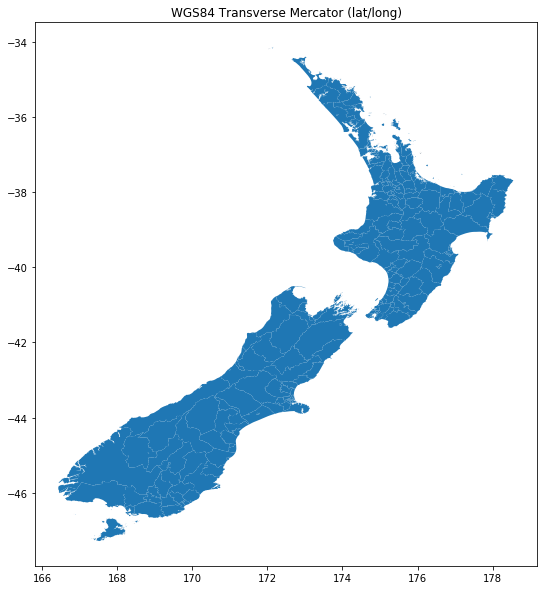

In [4]:
ax = basemap.plot(figsize=(10,10))
ax.set_title('WGS84 Transverse Mercator (lat/long)')
plt.show()

# 2. Load insurance policy data

In [6]:
# read data as pandas DataFrame
policies = pd.read_csv('data/raw/data.csv')

# convert to GeoDataFrame
policies = gpd.GeoDataFrame(
    policies,
    crs={'init': 'epsg:4167'}, # initialise CRS as NZGD2000 lat/long
    geometry=gpd.points_from_xy(policies.gd2000_xcoord, policies.gd2000_ycoord)
).to_crs(
    {'init' :'epsg:4326'}  # reproject to WGS84 Transverse Mercator CRS
).drop(
    ['X_Coord', 'Y_Coord', 'gd2000_xcoord', 'gd2000_ycoord'],
    axis=1
)

policies.head()

,SampleNo,DriverGender,DriverAge,YearsLicensed,Licensed Age,WindscreenExtension,RentalCar,Alarm,GarageType,FinanceType,...,Start Date,Immobliser,HasPassengerFare,HasTradeUse,HCusinessUseType,IsACustomer,Vehicle Year,Make,Model,geometry
0,1,Female,49,31,18,No,No,No,Carport,NO,...,TODAY,No,No,No,No,No,2019,Foton,Sauvana,POINT (175.02788 -41.14489)
1,2,Male,28,9,19,No,No,No,Garage,NO,...,TODAY,No,No,No,No,No,2008,Fiat,Ducato,POINT (175.01538 -41.14356)
2,3,Male,27,9,18,No,No,No,Carport,NO,...,TODAY,No,No,No,No,No,2018,Holden,Astra,POINT (175.14368 -41.09620)
3,4,Male,52,34,18,No,No,No,Driveway,NO,...,TOMORROW,No,No,No,No,No,2010,Suzuki,Grand Vitara,POINT (175.10925 -41.09523)
4,5,Male,31,12,19,No,No,Yes,Driveway,NO,...,TODAY,No,No,No,No,No,2002,Ford,Falcon,POINT (175.07158 -41.11921)


In [7]:
policies.shape

(3000, 35)

# 3. Spatial join basemap and policy data

In [8]:
df = gpd.sjoin(
    policies,
    basemap,
    how='left',  # keep row for each individual policy
    op='within'  # join ward in which point lies
)

df.head()

,SampleNo,DriverGender,DriverAge,YearsLicensed,Licensed Age,WindscreenExtension,RentalCar,Alarm,GarageType,FinanceType,...,HasTradeUse,HCusinessUseType,IsACustomer,Vehicle Year,Make,Model,geometry,index_right,Ward_no,Ward_name
0,1,Female,49,31,18,No,No,No,Carport,NO,...,No,No,No,2019,Foton,Sauvana,POINT (175.02788 -41.14489),66,04599,Area Outside Ward
1,2,Male,28,9,19,No,No,No,Garage,NO,...,No,No,No,2008,Fiat,Ducato,POINT (175.01538 -41.14356),66,04599,Area Outside Ward
2,3,Male,27,9,18,No,No,No,Carport,NO,...,No,No,No,2018,Holden,Astra,POINT (175.14368 -41.09620),66,04599,Area Outside Ward
3,4,Male,52,34,18,No,No,No,Driveway,NO,...,No,No,No,2010,Suzuki,Grand Vitara,POINT (175.10925 -41.09523),66,04599,Area Outside Ward
4,5,Male,31,12,19,No,No,Yes,Driveway,NO,...,No,No,No,2002,Ford,Falcon,POINT (175.07158 -41.11921),66,04599,Area Outside Ward


In [9]:
# groupby + aggregate by ward
df = df.groupby(
    'Ward_name'
).agg(
    # newcol=(col, aggfunc)
    n_policies=('SampleNo', 'count'),
    avg_age=('DriverAge', 'mean'),
    avg_n_claims=('Num Claims', 'mean'),
    avg_sum_insured=('Vehicle Sum Insured', 'mean'),
    avg_vehicle_year=('Vehicle Year', 'mean')
).reset_index()

df.head()

,Ward_name,n_policies,avg_age,avg_n_claims,avg_sum_insured,avg_vehicle_year
0,Ahuriri Ward,4,34.250000,0.000000,32939.500000,2012.500000
1,Albany Ward,233,35.021459,0.330472,32538.197425,2014.094421
2,Albert-Eden-Roskill Ward,89,34.921348,0.483146,29668.303371,2013.550562
3,Alexandra Ward,15,33.266667,0.266667,32473.000000,2012.866667
4,Amberley Ward,15,30.133333,0.266667,30487.133333,2012.600000


In [10]:
# add geometry of each ward
df = df.merge(basemap, how='outer', on='Ward_name')
# re-assert CRS
df = gpd.GeoDataFrame(df, crs=basemap.crs)
# replace nulls with 0s
df = df.fillna(
    {
        'n_policies':0,
        'avg_age':0,
        'avg_n_claims':0,
        'avg_sum_insured':0,
        'avg_vehicle_year':0
    }
)

df.head()

,Ward_name,n_policies,avg_age,avg_n_claims,avg_sum_insured,avg_vehicle_year,Ward_no,geometry
0,Ahuriri Ward,4.0,34.250000,0.000000,32939.500000,2012.500000,06801,"MULTIPOLYGON (((169.64249 -44.58830, 169.64253..."
1,Ahuriri Ward,4.0,34.250000,0.000000,32939.500000,2012.500000,03101,"MULTIPOLYGON (((176.84970 -39.42650, 176.84966..."
2,Albany Ward,233.0,35.021459,0.330472,32538.197425,2014.094421,07602,"MULTIPOLYGON (((174.73881 -36.62435, 174.73881..."
3,Albert-Eden-Roskill Ward,89.0,34.921348,0.483146,29668.303371,2013.550562,07607,"MULTIPOLYGON (((174.75931 -36.86803, 174.75940..."
4,Alexandra Ward,15.0,33.266667,0.266667,32473.000000,2012.866667,06904,"MULTIPOLYGON (((169.36713 -45.25106, 169.36603..."


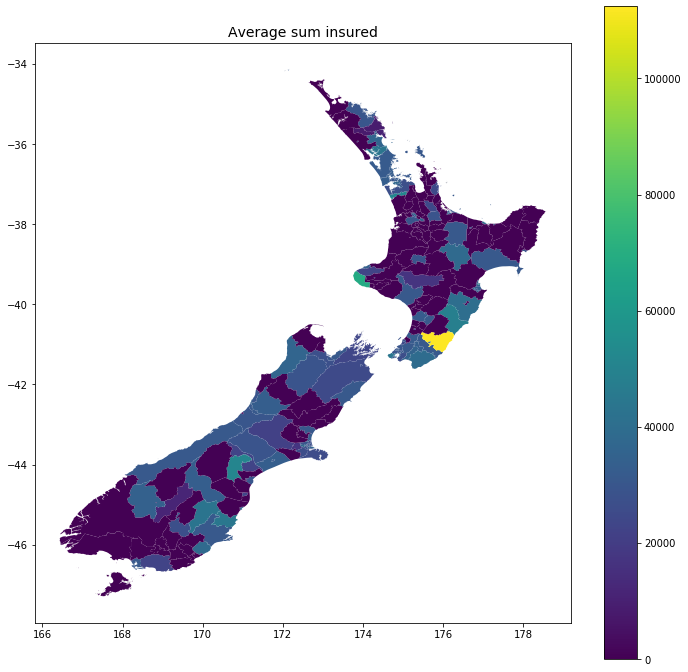

In [11]:
ax = df.plot(column='avg_sum_insured',
             legend=True,
             figsize=(12, 12))

ax.set_title('Average sum insured', fontsize=14)
plt.show()

# 4. Save processed data

In [12]:
policies.to_file('data/processed/policies.geojson', driver='GeoJSON')
df.to_file('data/processed/wards.geojson', driver='GeoJSON')